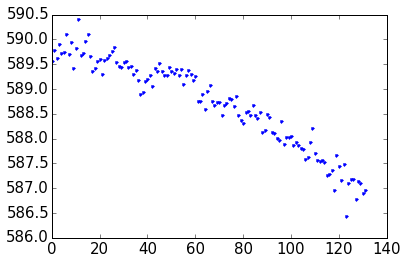

In [1]:
%matplotlib inline
import pyfits
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 15
from matplotlib import pyplot as plt
import sys
#sys.path.append('../')
#import photPack2
from astropy.time import Time
import emcee
import george
from george import kernels

fluxes = np.load('../photoutputs/fluxes.npy')
errors = np.load('../photoutputs/errors.npy')
times = np.load('../photoutputs/times.npy')
airmass = np.load('../photoutputs/airmass.npy')
wavelengthbincenters = np.load('../photoutputs/wavelengthbincenters.npy')
exposuredurs = np.load('../photoutputs/exposuredurs.npy')
wavelengthbounds = np.load('../photoutputs/wavelengthbounds.npy')

#centroids = np.load('../photoutputs/centroids.npy')
centroids = np.load('../photoutputs_tmp/finecentroids.npy')

plt.plot(centroids[::2,0],'.')
plt.show()

## Build spectrum with first few exposures

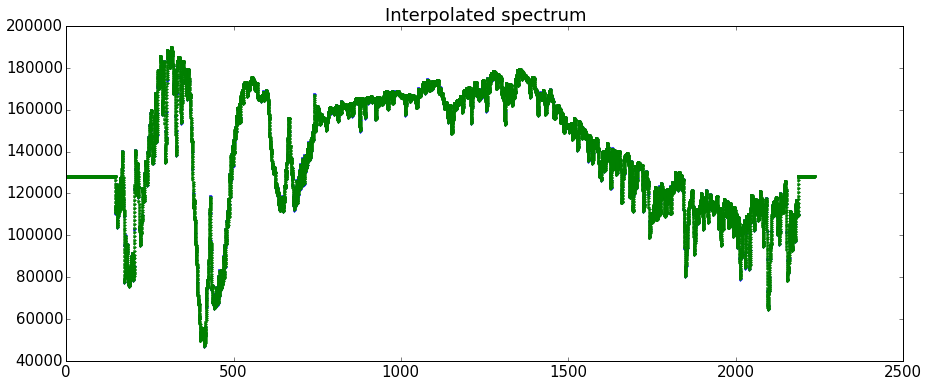

In [2]:
wasp6paths_nodsub = ["%s%04d%s" % ('/local/tmp/mosfire/2014sep18_analysis/m140918_', \
                         i,'n_nobadpxl.fits') for i in range(365,629,1)]

for imgind in range(0,10,2):
#    print wasp6paths_nodsub[imgind]
    image = pyfits.getdata(wasp6paths_nodsub[imgind])
    window = 5
    crop = image[centroids[:,0][imgind]-window:centroids[:,0][imgind]+window, :]
    if imgind == 0:
        cropsum = np.sum(crop, axis=0)
    else: 
        cropsum += np.sum(crop, axis=0)
cropsum[cropsum == 0] = np.mean(cropsum)

x_interp = np.linspace(0, len(cropsum), 10*len(cropsum))
ref_interp = np.interp(x_interp, np.arange(len(cropsum)), cropsum)        

plt.figure(figsize=(15,6))
plt.plot(np.arange(len(cropsum)), cropsum,'.')
plt.plot(x_interp, ref_interp,'.')
plt.title('Interpolated spectrum')
#plt.xlim([500, 503])
plt.show()

In [3]:
skipfirst = 0
bestcc = np.zeros(len(wasp6paths_nodsub)/2)

for i in np.arange(skipfirst,len(wasp6paths_nodsub),2):#[:5]:
    imgind = i#50
    image = pyfits.getdata(wasp6paths_nodsub[imgind])
    window = 5
    crop = image[centroids[:,0][imgind]-window:centroids[:,0][imgind]+window, :]
    cropsum = np.sum(crop, axis=0)
    cropsum_interp = np.interp(x_interp, np.arange(len(cropsum)), cropsum)
    cropsum_interp[cropsum_interp == 0] = np.mean(cropsum_interp)

    cc = np.correlate(cropsum_interp, ref_interp,'same')
    bestcc[i/2] = x_interp[np.argmax(cc)]

#     plt.plot(cropsum_interp)
#     plt.plot(ref_interp)



Plate scale: 0.180"/pixel
Net motion: 0.670 pixels/hour
Total drift: 3.22 pixels = 0.58"
drift in spectral direction: 1.268 pixels


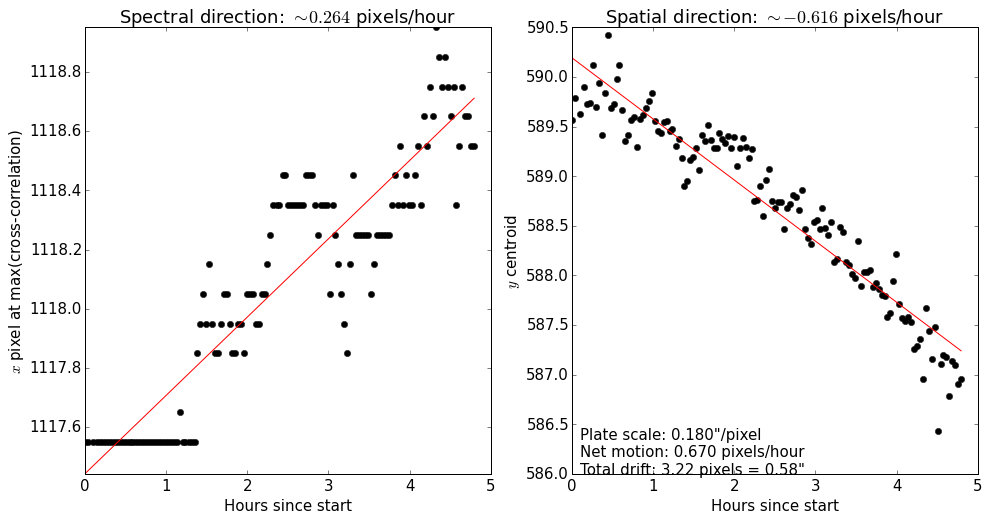

In [4]:
everyothertimes = (times[::2] - np.min(times))*24
spec_bestp = np.polyfit(everyothertimes[skipfirst:], bestcc[skipfirst:], 1)
spat_bestp = np.polyfit(everyothertimes, centroids[::2,0], 1)

matplotlib.rcParams['axes.formatter.useoffset']=False
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(everyothertimes, bestcc,'ko')
ax[0].plot(everyothertimes, np.polyval(spec_bestp, everyothertimes), 'r')
ax[0].set_ylabel('$x$ pixel at max(cross-correlation)')
ax[0].set_xlabel('Hours since start')
ax[0].set_title('Spectral direction: $\sim{0:.3f}$ pixels/hour'.format(spec_bestp[0]))
ax[0].set_ylim([spec_bestp[1], np.max(bestcc)])

ax[1].set_title('Spatial direction: $\sim{0:.3f}$ pixels/hour'.format(spat_bestp[0]))
ax[1].plot(everyothertimes, centroids[::2,0], 'ko')
ax[1].plot(everyothertimes, np.polyval(spat_bestp, everyothertimes), 'r')
ax[1].set_ylabel('$y$ centroid')
ax[1].set_xlabel('Hours since start')

netmotion = np.sqrt(spat_bestp[0]**2 + spec_bestp[0]**2)
platescale = 0.1798
totaldrift = netmotion*np.max(everyothertimes)
note0='Plate scale: {0:.3f}"/pixel'.format(platescale)
note1='Net motion: {0:.3f} pixels/hour'.format(netmotion)
note2='Total drift: {0:.2f} pixels = {1:.2f}"'.format(totaldrift, totaldrift*platescale)
print '\n'.join([note0, note1,note2])
ax[1].annotate('\n'.join([note0,note1,note2]), xy=(0.1,586), textcoords='data', ha='left')
print 'drift in spectral direction: {0:.3f} pixels'.format(spec_bestp[0]*np.max(everyothertimes))
fig.savefig('plots/drift.pdf',bbox_inches='tight')
plt.show()

In [5]:
netmotion = np.sqrt(spat_bestp[0]**2 + spec_bestp[0]**2)
print 'Net motion: {0:.3f} pixels/hour'.format(netmotion)
print 'Total pixel drift over night: ~{0:.2f} pixels'.format(netmotion*np.max(everyothertimes))

Net motion: 0.670 pixels/hour
Total pixel drift over night: ~3.22 pixels


In [6]:
wasp6paths_nodsub = ["%s%04d%s" % ('/local/tmp/mosfire/2014sep18_analysis/m140918_', \
                         i,'n_nobadpxl.fits') for i in range(365,629,1)][::2]
elevations = np.zeros(len(wasp6paths_nodsub))
rotations = np.zeros(len(wasp6paths_nodsub))
for i, imagepath in zip(range(len(wasp6paths_nodsub)), wasp6paths_nodsub):
    if i % 50 == 0: print i, 'of', len(wasp6paths_nodsub)
    #image = pyfits.getdata(imagepath)
    header = pyfits.getheader(imagepath)
    elevations[i] = header['EL']
    rotations[i] = header['ROTPPOSN']

0 of 132
50 of 132
100 of 132


In [7]:
deltax = bestcc - bestcc.min()
deltay = centroids[::2,0] - centroids[::2,0][0]
outputmatrix = np.vstack([deltax, deltay, elevations, rotations]).T
np.savetxt('MOSFIREguidingdrift.txt', 
           outputmatrix)


In [8]:
%%bash
more MOSFIREguidingdrift.txt

::::::::::::::
MOSFIREguidingdrift.txt
::::::::::::::
0.000000000000000000e+00 0.000000000000000000e+00 3.665945081000000272e+01 2.201985163999999884e+01
0.000000000000000000e+00 2.194108891686710194e-01 3.703063107999999914e+01 2.144049083000000167e+01
0.000000000000000000e+00 5.558004853014608670e-02 3.757017489999999782e+01 2.057325163000000146e+01
0.000000000000000000e+00 3.333724756903393427e-01 3.791258633999999716e+01 2.000006528000000117e+01
0.000000000000000000e+00 1.573177070954443479e-01 3.828734925999999916e+01 1.936167049000000162e+01
0.000000000000000000e+00 1.715385209944315648e-01 3.858531849999999963e+01 1.884086900999999870e+01
0.000000000000000000e+00 5.499279160979995140e-01 3.888583185000000242e+01 1.830384872000000129e+01
0.000000000000000000e+00 1.303565226040745983e-01 3.918125696999999974e+01 1.776256625999999983e+01
0.000000000000000000e+00 3.712419720602611051e-01 3.947524409999999762e+01 1.721342951000000099e+01
0.000000000000000000e+00 -1.520460227877720172

In [9]:
pwd

u'/astro/users/bmmorris/git/research/keck/2014september/analysis/bothnods/checks'